In [1]:
#Setting
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import datetime
import re
import warnings
warnings.filterwarnings("ignore")

In [2]:
def call_df(table_name):
    with open('config.json', 'r') as f:
        config = json.load(f)
        
    conn = psycopg2.connect(user = config['USER'],
                              password = config['PASSWORD'],
                              host = config['HOST'],
                              port = config['PORT'],
                              database = config['DATABASE'])
    
    sql = f'SELECT * FROM {table_name}'
    df = pd.read_sql_query(sql, conn)
    conn.close()
    return df

In [3]:
district = call_df('crawling_db.district_table')
apartment = call_df('crawling_db.apartment_table').drop(columns='table_id')
school = call_df('crawling_db.school_table').drop(columns='table_id')
subway = call_df('crawling_db.subway_table').drop(columns='table_id')

In [4]:
df = (apartment.
      merge(district, how='left', on='district_id').
      merge(school, how='left', on='apartment_id').
      merge(subway, how='left',on='apartment_id'))

In [5]:
#전처리
df['apartment_floor_min'] = pd.to_numeric(df['apartment_floor_min'])
df['apartment_floor_max'] = pd.to_numeric(df['apartment_floor_max'])
df['school_students'] = pd.to_numeric(df['school_students'])
df = df.drop(['district_id','apartment_id'],axis=1)
df['school_addr_town'] = df['school_addr_town'].apply(lambda x: re.split('\d',x)[0])

In [6]:
df.head(15)

,apartment_addr_town,apartment_builder,apartment_build_year,apartment_build_month,apartment_floor_min,apartment_floor_max,apartment_parking,district_name,school_name,school_dist,school_addr_district,school_addr_town,school_students,st_name,st_dist,st_volume
0,개포동,LG건설(주),2004,6,20,22,2.36,강남구,서울대진초등학교,1,1,개포로,316.0,학여울역,0.002592,1
1,개포동,삼성물산(주),2020,9,7,35,1.71,강남구,서울구룡초등학교,2,1,개포로,492.0,매봉역,0.009325,1
2,개포동,상지건영(주),2003,3,10,10,2.27,강남구,서울개일초등학교,4,1,개포로,837.0,구룡역,0.002699,1
3,개포동,대한주택공사,1982,11,5,5,0.49,강남구,서울개원초등학교,1,1,선릉로,131.0,구룡역,0.007869,1
4,개포동,대한주택공사,1982,11,5,5,0.40,강남구,서울양전초등학교,1,1,개포로,455.0,개포동역,0.004453,1
5,개포동,대한주택공사,1983,10,13,14,0.97,강남구,서울양전초등학교,3,1,개포로,455.0,개포동역,0.001978,1
6,개포동,대한주택공사,1983,10,13,15,0.28,강남구,서울양전초등학교,2,1,개포로,455.0,개포동역,0.001076,1
7,개포동,대한주택공사,1983,10,15,15,0.44,강남구,서울양전초등학교,2,1,개포로,455.0,개포동역,0.002930,1
8,개포동,㈜GS건설,2023,2,7,35,1.74,강남구,,0,1,,NaN,개포동역,0.004421,1
9,개포동,현대건설,1986,7,9,9,0.00,강남구,서울구룡초등학교,1,1,개포로,492.0,매봉역,0.005728,1


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8016 entries, 0 to 8015
Data columns (total 16 columns):
apartment_addr_town      8016 non-null object
apartment_builder        8016 non-null object
apartment_build_year     8016 non-null int64
apartment_build_month    8016 non-null int64
apartment_floor_min      8016 non-null int64
apartment_floor_max      8016 non-null int64
apartment_parking        8016 non-null float64
district_name            8016 non-null object
school_name              8016 non-null object
school_dist              8016 non-null int64
school_addr_district     8016 non-null int64
school_addr_town         8016 non-null object
school_students          7176 non-null float64
st_name                  8016 non-null object
st_dist                  8016 non-null float64
st_volume                8016 non-null int64
dtypes: float64(3), int64(7), object(6)
memory usage: 1.0+ MB


In [8]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

In [9]:
#Encoding 전, 데이터 복사시키기
temp = df.copy()

In [10]:
#모든 범주형 자료를 label encoder를 이용하여 숫자형으로 변환

label_encoder.fit(temp.apartment_addr_town)
apartment_addr_town_encoded = label_encoder.transform(temp.apartment_addr_town)
temp.apartment_addr_town = apartment_addr_town_encoded

label_encoder.fit(temp.apartment_builder)
apartment_builder_encoded = label_encoder.transform(temp.apartment_builder)
temp.apartment_builder = apartment_builder_encoded

label_encoder.fit(temp.district_name)
district_name_encoded = label_encoder.transform(temp.district_name)
temp.district_name = district_name_encoded

label_encoder.fit(temp.school_name)
school_name_encoded = label_encoder.transform(temp.school_name)
temp.school_name = school_name_encoded

label_encoder.fit(temp.school_addr_town)
school_addr_town_encoded = label_encoder.transform(temp.school_addr_town)
temp.school_addr_town = school_addr_town_encoded

label_encoder.fit(temp.st_name)
st_name_encoded = label_encoder.transform(temp.st_name)
temp.st_name = st_name_encoded

temp.head(10)

,apartment_addr_town,apartment_builder,apartment_build_year,apartment_build_month,apartment_floor_min,apartment_floor_max,apartment_parking,district_name,school_name,school_dist,school_addr_district,school_addr_town,school_students,st_name,st_dist,st_volume
0,8,1176,2004,6,20,22,2.36,0,111,1,1,10,316.0,279,0.002592,1
1,8,2009,2020,9,7,35,1.71,0,56,2,1,10,492.0,97,0.009325,1
2,8,2102,2003,3,10,10,2.27,0,27,4,1,10,837.0,32,0.002699,1
3,8,1592,1982,11,5,5,0.49,0,26,1,1,146,131.0,32,0.007869,1
4,8,1592,1982,11,5,5,0.40,0,346,1,1,10,455.0,13,0.004453,1
5,8,1592,1983,10,13,14,0.97,0,346,3,1,10,455.0,13,0.001978,1
6,8,1592,1983,10,13,15,0.28,0,346,2,1,10,455.0,13,0.001076,1
7,8,1592,1983,10,15,15,0.44,0,346,2,1,10,455.0,13,0.002930,1
8,8,1186,2023,2,7,35,1.74,0,0,0,1,0,NaN,13,0.004421,1
9,8,3515,1986,7,9,9,0.00,0,56,1,1,10,492.0,97,0.005728,1


In [11]:
#학생 수에 갑자기 na 값이 생겨서 모두 0 으로 대체
temp = temp.fillna(0.0)

In [12]:
#Clustering은 분산에 민감하므로, 숫자형 자료는 scaling 해준다.
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

In [13]:
temp_for_scaling = temp[['apartment_floor_min','apartment_floor_max','apartment_parking','school_students','st_dist']]
print(ss.fit(temp_for_scaling))
temp_scaled = ss.transform(temp_for_scaling)
temp_scaled = pd.DataFrame(temp_scaled,columns=temp_for_scaling.columns)
temp = pd.concat([temp[['apartment_addr_town', 'apartment_builder','apartment_build_year','apartment_build_month','district_name','school_name','school_dist','school_addr_district','school_addr_town','st_name','st_volume']], temp_scaled], axis=1)
temp.head()

StandardScaler(copy=True, with_mean=True, with_std=True)


,apartment_addr_town,apartment_builder,apartment_build_year,apartment_build_month,district_name,school_name,school_dist,school_addr_district,school_addr_town,st_name,st_volume,apartment_floor_min,apartment_floor_max,apartment_parking,school_students,st_dist
0,8,1176,2004,6,0,111,1,1,10,279,1,2.097438,1.448713,1.899468,-0.905557,-0.832240
1,8,2009,2020,9,0,56,2,1,10,97,1,-0.439529,3.333310,0.940510,-0.500065,0.953997
2,8,2102,2003,3,0,27,4,1,10,32,1,0.145925,-0.290915,1.766689,0.294790,-0.803781
3,8,1592,1982,11,0,26,1,1,146,32,1,-0.829831,-1.015759,-0.859379,-1.331784,0.567727
4,8,1592,1982,11,0,346,1,1,10,13,1,-0.829831,-1.015759,-0.992158,-0.585311,-0.338445


# Modeling 

In [14]:
#K-means 군집화
from sklearn.cluster import KMeans
model = KMeans(n_clusters=8)
model.fit(temp)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [15]:
#군집 정보를 label에 입력
df['label'] = model.fit_predict(temp)
temp['label'] = model.fit_predict(temp)

In [16]:
temp

,apartment_addr_town,apartment_builder,apartment_build_year,apartment_build_month,district_name,school_name,school_dist,school_addr_district,school_addr_town,st_name,st_volume,apartment_floor_min,apartment_floor_max,apartment_parking,school_students,st_dist,label
0,8,1176,2004,6,0,111,1,1,10,279,1,2.097438,1.448713,1.899468,-0.905557,-0.832240,1
1,8,2009,2020,9,0,56,2,1,10,97,1,-0.439529,3.333310,0.940510,-0.500065,0.953997,4
2,8,2102,2003,3,0,27,4,1,10,32,1,0.145925,-0.290915,1.766689,0.294790,-0.803781,4
3,8,1592,1982,11,0,26,1,1,146,32,1,-0.829831,-1.015759,-0.859379,-1.331784,0.567727,7
4,8,1592,1982,11,0,346,1,1,10,13,1,-0.829831,-1.015759,-0.992158,-0.585311,-0.338445,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8011,277,2796,2004,7,24,167,3,25,74,260,1,-0.439529,-0.725821,-0.106966,-0.516193,-1.215924,5
8012,277,3451,1997,10,24,224,2,25,74,258,2,2.682892,2.173558,-0.106966,-0.106093,-1.006467,2
8013,277,513,2003,11,24,167,5,25,74,260,1,-0.829831,-0.725821,-0.092213,-0.516193,-0.482424,6
8014,277,323,2007,3,24,167,7,25,74,260,1,-0.829831,-0.725821,0.276617,-0.516193,-0.970597,3


<Figure size 432x288 with 0 Axes>

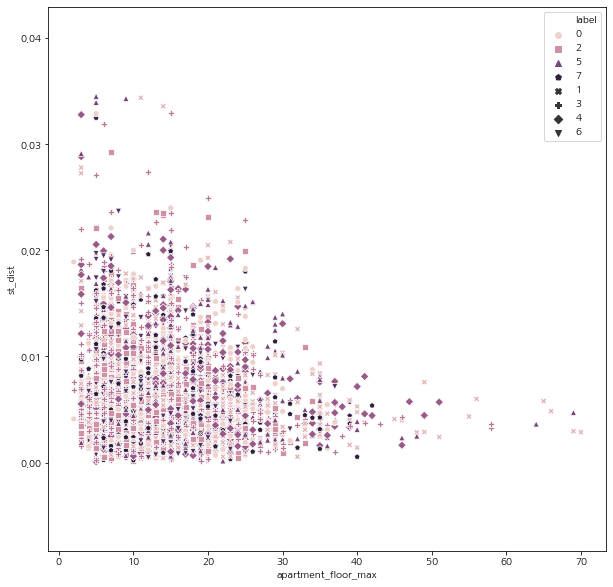

In [20]:
#어느정도의 군집은 일어났으나..
fig = plt.figure()
plt.subplots(figsize=(10,10))
sns.scatterplot(x='apartment_floor_max', 
                y='st_dist', 
                hue='label', # different colors by group
                style='label', # different shapes by group
                data=df)

In [25]:
#강남끼리 잘 묶인걸로 보아 이것도 괜찮은 것 같고..
df[df['label'] == 7].head(25)

,apartment_addr_town,apartment_builder,apartment_build_year,apartment_build_month,apartment_floor_min,apartment_floor_max,apartment_parking,district_name,school_name,school_dist,school_addr_district,school_addr_town,school_students,st_name,st_dist,st_volume,label
14,개포동,주식회사에이치엠건설,2019,8,8,8,1.05,강남구,,0,1,,NaN,양재시민의숲역,0.007941,1,7
17,개포동,"진덕산업(주),성원건설(주)",1992,10,15,15,1.00,강남구,서울대진초등학교,6,1,개포로,316.0,학여울역,0.002411,1,7
53,논현동,이수건설(주),2005,3,4,6,2.26,강남구,서울논현초등학교,11,1,강남대로,339.0,논현역,0.002224,1,7
65,논현동,주식회사보경종합건설,2019,6,6,6,0.51,강남구,서울논현초등학교,4,1,강남대로,339.0,신논현역,0.002358,1,7
73,논현동,이례건설(주),2003,4,5,6,1.33,강남구,서울학동초등학교,10,1,선릉로,485.0,학동역,0.001756,1,7
81,논현동,이앤시종합건설(주),2004,3,5,5,1.30,강남구,서울논현초등학교,15,1,강남대로,339.0,논현역,0.003156,1,7
105,논현동,은탑산업개발(주),2003,8,6,7,1.66,강남구,서울논현초등학교,10,1,강남대로,339.0,논현역,0.002384,1,7
108,논현동,정일종합건설(주),2004,4,5,7,1.00,강남구,서울학동초등학교,12,1,선릉로,485.0,학동역,0.004535,1,7
109,논현동,지고C&D,2003,10,7,7,0.96,강남구,서울논현초등학교,11,1,강남대로,339.0,신사역,0.002722,1,7
126,논현동,은탑산업개발(주),2001,6,5,6,1.56,강남구,서울논현초등학교,10,1,강남대로,339.0,논현역,0.002349,1,7
